# Focused scalar beam

In this example we use scalar and vector difraction to compute electromagnetic field in the vicinity of the objective lens focal plane. Technique is explained in [[1]](https://doi.org/10.1364/OE.565420). This notebook was used to create plots in [2]

For scalar beams (with constant polarization) the procedure to calculate the electromagnetic field is as follows:

1. We write a scalar field $u'$ in the Fourier plane of the objective lens (coordinate system $S'$)
2. We use lens transform operator $\mathcal{L}_f$ to compute $u$ in the focal plane (coordinate system $S$)
3. We use field propagation operator $\mathcal{\Phi}_z$ to compute $u(z)$
4. We convert scalar field $u(z)$ first to a generalized Jones vector field $\vec{j}(z)=(u_x,u_y)$ and use a beam constructor $\mathcal{B}_f$ to compute $\vec{f}=(\mathcal{H}_z,\mathcal{E}_x,\mathcal{H}_y,\mathcal{E}_y,\mathcal{H}_x,\mathcal{E}_z)$ as explained in [2].

<img src="scalar_lens_transform.png" width = 500 alt="scalar_lens_transform.png shows a scheme of the experimental geometry" />

[[1]](https://doi.org/10.1364/OE.565420) Petelin, A. & Muševič, I. , Focused beam propagation in cholesteric
liquid crystals. *Opt. Express* **33**, 32955–32975.

[2] Petelin, A., Fokusirani snopi svetlobe, *Obzornik za matematiko in fiziko* 

## Usage notes

To use this notebook you can modify experimental parameters and then click run -> Run All Cells (or press Shift->Enter to execute individual cells).

Note that the implementation is based on unitless fields. You can use SI_E_field, SI_H_field and SI_intensity functions if you want to convert unitless fields to proper physical fields in SI units.


In [1]:
# import required tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.special as sp # for laguerre beams
from ipywidgets import interact # for interactive plots

## Experimental parameters

In [2]:
# Settable user parameters

# Lens transform settings
#------------------------

#: number of pixels. You may need to reduce this number if running inside jupyter lite
N = 200
#: pixel size in the imae plane
IMAGE_PLANE_PIXEL_SIZE = 40e-9 # p [m]
#: lens effective focal length
FOCAL_LENGTH = 4e-3 # f [m]
#: refractive index of the medium 
REFRACTIVE_INDEX = 1.5
#: numerical aperture of the lens, should be less than REFRACTIVE_INDEX
NA = 1.4
#: whether to smooth down aperture edge. 
SMOOTH_APERTURE = False

# Input beam settings
#--------------------

#: input beam wavelength
WAVELENGTH = 500e-9 # \lambda [m]
#: input beam waist at the Fourier plane
WAIST = 1e-3 # w_0 [m]
#: The p parameter of Laguerre-Gaussian beam
P = 0
#: The l parameter of Laguerre-Gaussian beam (can be negative)
L = 0
#: input beam center x offset 
X0 = -3e-3
#: input beam center y offset 
Y0 = 0
#: input beam center z offset
Z0 = 0
#: input beam center intensitiy
INTENSITY = 1 # unitless
#: scaling factor for conversion from unitless jones or scalar field to SI units
E0 = 1 #V/m
#: input field polarization (jones) vector
POLARIZATION = (1,0)

# Display settings
#-----------------

#: matplotlib figsize
FIGSIZE12 = (7.5,3)
FIGSIZE32 = (7.5,9)
#: whether to plot coordinates matrices
PLOT_COORDINATES = False
#: whether to save plots
SAVE_FIG = False


In [3]:
# internal parameters

#: whether to bypass user settings and force normal incidence with modified waist and resolution (to construct plots for the article)
NORMAL_INCIDENCE = False

if NORMAL_INCIDENCE:
    INCIDENCE = "normal"
    WAIST = WAIST*3 # w_0 [m]
    X0 = 0
    Y0 = 0
    Z0 = 0
    #IMAGE_PLANE_PIXEL_SIZE/=2 
else:
    INCIDENCE = "offaxis"

# Computed parameters
# Do not change manually!

#: impedance of vacuum
IMPEDANCE = 377 #Ohm
#: scaling factor for conversion from unitless intensity to SI units
I0 = E0**2/IMPEDANCE
#: array shape
SHAPE = (N,N)
#: computed image size in coordinate system S
IMAGE_PLANE_SIZE = N * IMAGE_PLANE_PIXEL_SIZE # L [m]
#: pixel size in coordinate system S'
FOURIER_PLANE_PIXEL_SIZE = WAVELENGTH * FOCAL_LENGTH / IMAGE_PLANE_SIZE # p' [m]
#: image size in coordinate system S'
FOURIER_PLANE_SIZE = N * FOURIER_PLANE_PIXEL_SIZE # L' [m]

FOURIER_PLANE_BETA_STEP = WAVELENGTH/FOURIER_PLANE_SIZE
IMAGE_PLANE_BETA_STEP = WAVELENGTH/IMAGE_PLANE_SIZE

#: wave vector in vacuum
K0 = 2*np.pi/WAVELENGTH
#: wave vector in medium
K = K0 * REFRACTIVE_INDEX
#: Gaussian beam's Rayleigh length
ZR = K0 * WAIST**2/2
#: Coordinates used for z scan
Z = np.linspace(-IMAGE_PLANE_SIZE/2,IMAGE_PLANE_SIZE/2,N)
#: 
ZINDEX = int(N*0.55)

def SI_E_field(field):
    return E0 * field

def SI_H_field(field):
    return E0 * field / IMPEDANCE

def SI_intensity(intensity):
    return I0 * intensity

def print_lens_parameters():
    print("Lens transform parameters")
    print("-------------------------")
    print(f"Computation domain size (L'->L) : {FOURIER_PLANE_SIZE*1000} mm -> {IMAGE_PLANE_SIZE*1000000} um")
    print(f"Lens focal length (f) : {FOCAL_LENGTH*1000} mm")
    print(f"Lens NA (f) : {NA}")
    print(f"Imersion refractive index : {REFRACTIVE_INDEX}" )

def print_beam_parameters(): 
    print("Input beam parameters")
    print("---------------------")
    print(f"Wavelength : {WAVELENGTH*10**9} nm" )
    print(f"Beam waist size: {WAIST*1000} mm")
    print(f"Beam Rayleigh length: {ZR} m")
    print(f"Beam center intesnity: {INTENSITY} = {SI_intensity(INTENSITY)*1000} mW")
    print(f"Beam center: {(X0*1000,Y0*1000, Z0*1000)} mm") 
    print(f"Focal plane z: ", expected_focal_z()*1000000, "um")

def print_parameters():
    print_lens_parameters()
    print()
    print_beam_parameters()

def expected_focal_z():
    return -Z0*FOCAL_LENGTH**2/(Z0**2+ZR**2)


def expected_focal_z():
    z = np.asarray([[1,-Z0],[0,1]])
    d1 = np.asarray([[1,FOCAL_LENGTH],[0,1]])
    d2 = np.asarray([[1,FOCAL_LENGTH],[0,1]])
    f = np.asarray([[1,0],[-1/FOCAL_LENGTH,1]])
    n = np.asarray([[1,0],[0,1/REFRACTIVE_INDEX]])
    m = n@d2@f@d1@z
    a = m[0,0]
    b = m[0,1]
    c = m[1,0]
    d = m[1,1]
    q = 1j*ZR
    return -((a*q + b)/(c*q + d)).real 
    return -Z0*FOCAL_LENGTH**2/(Z0**2+ZR**2)

_PARAMETERS_OK = True

print_parameters()

Lens transform parameters
-------------------------
Computation domain size (L'->L) : 50.0 mm -> 8.0 um
Lens focal length (f) : 4.0 mm
Lens NA (f) : 1.4
Imersion refractive index : 1.5

Input beam parameters
---------------------
Wavelength : 500.0 nm
Beam waist size: 1.0 mm
Beam Rayleigh length: 6.283185307179587 m
Beam center intesnity: 1 = 2.6525198938992043 mW
Beam center: (-3.0, 0, 0) mm
Focal plane z:  -1.2490009027033014e-13 um


## Coordinates and matrices

In [4]:
# create and plot coordinates matrices

print(f"Real space pixel size p' = {FOURIER_PLANE_PIXEL_SIZE*1000} mm" )
print(f"Real space pixel size p = {IMAGE_PLANE_PIXEL_SIZE*1e6} um" )

nvec = np.fft.fftfreq(N,d = 1/N) 
mvec = np.fft.fftfreq(N,d = 1/N) 

#: coordinate system S'
xvec_prime = nvec * FOURIER_PLANE_PIXEL_SIZE
yvec_prime = mvec * FOURIER_PLANE_PIXEL_SIZE
ymat_prime, xmat_prime = np.meshgrid(yvec_prime,xvec_prime, indexing = "ij")

#: coordinae ststem S
xvec = nvec * IMAGE_PLANE_PIXEL_SIZE
yvec = mvec * IMAGE_PLANE_PIXEL_SIZE
ymat,xmat = np.meshgrid(yvec,xvec, indexing = "ij")

if PLOT_COORDINATES:

    fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)
    im = axes[0].imshow(xmat_prime)
    axes[0].set_title("x'")
    axes[0].set_xlabel("n")
    axes[0].set_ylabel("m")
    plt.colorbar(im)
    im = axes[1].imshow(ymat_prime)
    plt.colorbar(im)
    axes[1].set_title("y'")
    axes[1].set_xlabel("n")
    axes[1].set_ylabel("m")
    plt.tight_layout()
    
    fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)
    im = axes[0].imshow(xmat)
    axes[0].set_title("x")
    axes[0].set_xlabel("n")
    axes[0].set_ylabel("m")
    plt.colorbar(im)
    im = axes[1].imshow(ymat)
    plt.colorbar(im)
    axes[1].set_title("y")
    axes[1].set_xlabel("n")
    axes[1].set_ylabel("m")
    plt.tight_layout()

Real space pixel size p' = 0.25 mm
Real space pixel size p = 0.04 um


Reciprocal space pixel size \delta\beta' = 9.999999999999999e-06
Reciprocal space pixel size \delta\beta = 0.0625


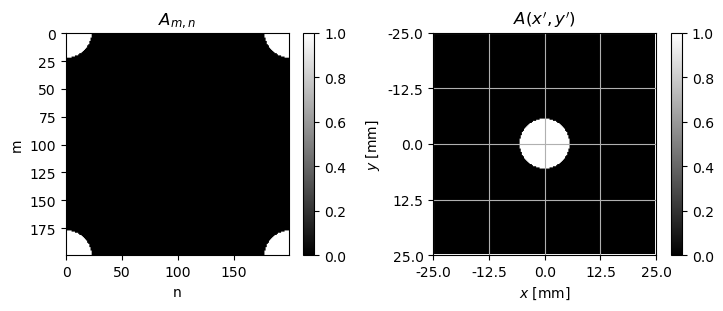

In [5]:
# Build propagation vector, aperture mask and aperture function

print(f"Reciprocal space pixel size \\delta\\beta' = {FOURIER_PLANE_BETA_STEP}" )
print(f"Reciprocal space pixel size \\delta\\beta = {IMAGE_PLANE_BETA_STEP}" )

# the propagation vector in S'
betaxvec_prime = nvec * FOURIER_PLANE_BETA_STEP 
betayvec_prime = mvec * FOURIER_PLANE_BETA_STEP 
betaymat_prime,betaxmat_prime = np.meshgrid(betayvec_prime,betaxvec_prime, indexing = "ij")

# the propagation vector in S
betaxvec = nvec * IMAGE_PLANE_BETA_STEP 
betayvec = mvec * IMAGE_PLANE_BETA_STEP 
betaymat ,betaxmat = np.meshgrid(betayvec,betaxvec, indexing = "ij")

beta2mat = betaymat**2+betaxmat**2

#: invalid propagation vector mask
aperture_mask = np.sqrt(beta2mat) > NA

#: aperture function A
if SMOOTH_APERTURE == True:
    aperture = np.tanh(2*(beta2mat/NA-1))
    aperture = aperture/aperture[0,0]
else:
    aperture = np.logical_not(aperture_mask)

UNITS_LABELS = {"m" : " [m]", "mm" : " [mm]", "um" : r" [$\mu$m]"}

def set_ticks(ax, size = (FOURIER_PLANE_SIZE,FOURIER_PLANE_SIZE), shape = SHAPE, nticks = (5,5), units = "mm", ylabel = "$y$",xlabel = "$x$"):

    if units == "mm":
        size = size[0]*1000, size[1]*1000

    elif units == "um":
        size = size[0]*1000000, size[1]*1000000
    
    elif units != "m":
        raise ValueError("unsupported units")
    
    xt = np.linspace(-0.5, 2*(shape[1]//2)+0.5, nticks[1])
    xl = np.linspace(-size[1]/2,size[1]/2,nticks[1])
    xl = [f"{x:.1f}" for x in xl]

    yt = np.linspace(-0.5, 2*(shape[0]//2)+0.5, nticks[0])
    yl = np.linspace(-size[0]/2,size[0]/2, nticks[0])
    yl = [f"{x:.1f}" for x in yl]
    
    ax.set_xticks(xt)
    ax.set_yticks(yt)
    ax.set_xticklabels(xl)
    ax.set_yticklabels(yl)
    
    if ylabel:
        ax.set_ylabel(ylabel + UNITS_LABELS[units])

    if xlabel:
        ax.set_xlabel(xlabel + UNITS_LABELS[units])
    ax.grid()


if PLOT_COORDINATES:
    fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)
    im = axes[0].imshow(betaxmat_prime)
    axes[0].set_title(r"$\beta_x'$")
    axes[0].set_xlabel("n")
    axes[0].set_ylabel("m")
    plt.colorbar(im)
    im = axes[1].imshow(betaymat_prime)
    plt.colorbar(im)
    axes[1].set_title(r"$\beta_y'$")
    axes[1].set_xlabel("n")
    axes[1].set_ylabel("m")
    plt.tight_layout()
    
    fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)
    im = axes[0].imshow(betaxmat)
    axes[0].set_title(r"$\beta_x$")
    axes[0].set_xlabel("n")
    axes[0].set_ylabel("m")
    plt.colorbar(im)
    im = axes[1].imshow(betaymat)
    plt.colorbar(im)
    axes[1].set_title(r"$\beta_y$")
    axes[1].set_xlabel("n")
    axes[1].set_ylabel("m")
    plt.tight_layout()

fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)
im = axes[0].imshow(aperture, cmap = "gray")
axes[0].set_title(r"$A_{m,n}$")
axes[0].set_xlabel("n")
axes[0].set_ylabel("m")
plt.colorbar(im)
im = axes[1].imshow(np.fft.fftshift(aperture), cmap = "gray")
plt.colorbar(im)
axes[1].set_title(r"$A(x',y')$")
axes[1].set_xlabel("n")
axes[1].set_ylabel("m")
plt.tight_layout()

set_ticks(axes[1], units = r"mm")



In [6]:
# Construct matrices

costheta_prime = np.sqrt(1-betaymat_prime**2-betaxmat_prime**2)

sintheta = np.sqrt(beta2mat)/REFRACTIVE_INDEX
sintheta[aperture_mask] = 0.
costheta = np.sqrt(1-sintheta**2)    
phimat = np.arctan2(betaymat,betaxmat)
cosphi = np.cos(phimat)
sinphi = np.sin(phimat)

#: the propagation constant in S
ALPHA_MAT = REFRACTIVE_INDEX * costheta

#: the propagation constant in S'
ALPHA_MAT_PRIME = costheta_prime

#: NxNx2x2 rotation matrix
_rot_mat = np.zeros(SHAPE + (2,2))
_rot_mat[...,0,0] = cosphi 
_rot_mat[...,1,1] = cosphi 
_rot_mat[...,0,1] = -sinphi 
_rot_mat[...,1,0] = sinphi

#: NxNx4x4 matrix R
rot_mat = np.zeros(SHAPE + (4,4))
rot_mat[...,0::2,0::2] = _rot_mat
rot_mat[...,1::2,1::2] = _rot_mat

#: NxNx4x4 matrix R'
rot_mat_prime = np.zeros(SHAPE + (4,4))
rot_mat_prime[...,0::2,0::2] = _rot_mat
rot_mat_prime[...,1::2,1::2] = np.transpose(_rot_mat,axes = (0,1,3,2))

# R^T
rot_matT = np.transpose(rot_mat, axes=(0,1,3,2))

n = REFRACTIVE_INDEX #alias

# NxNx4x4 F' matrix in coordinate system S
field_mat_prime = np.zeros(SHAPE + (4,4))
field_mat_prime[...,0,0] = costheta
field_mat_prime[...,0,1] = costheta
field_mat_prime[...,1,0] = n
field_mat_prime[...,0,1] = -n
field_mat_prime[...,2,2] = 1
field_mat_prime[...,2,3] = 1
field_mat_prime[...,3,2] = -n*costheta
field_mat_prime[...,3,3] = n * costheta
field_mat_prime[aperture_mask] = 0 # force zero for nonpropagating waves
field_mat_prime *= np.sqrt(2/n/costheta)[...,None,None] # normalization factor

# a full NxNx6x4 F matrix to compute field f
field_mat = np.zeros(SHAPE + (6,4))

# first rotate inner NxNx4x4 part
_field_mat = rot_mat_prime@field_mat_prime
field_mat[...,1:5,:] = _field_mat

# add missing two rows
field_mat[...,0,2] = n*sintheta * np.sqrt(2/n/costheta)
field_mat[...,0,3] = n*sintheta * np.sqrt(2/n/costheta)
field_mat[...,5,0] = -sintheta * np.sqrt(2/n/costheta)
field_mat[...,5,1] = sintheta * np.sqrt(2/n/costheta)

field_mat[aperture_mask] = 0 # force zero for nonpropagating waves

#: the NxNx6x4 B matrix to compute field f from the jones vector j
BEAM_MAT = field_mat@rot_matT

In [7]:
# Define field operators

def scalar2jones(scalar_field, polarization = POLARIZATION):
    """Converts a scalar field to a generalized jones vector field"""
    out = np.zeros(scalar_field.shape + (4,), dtype = scalar_field.dtype)
    out[...,0] = scalar_field * polarization[0]
    out[...,2] = scalar_field * polarization[1]
    return out
    
def lens_operator(scalar_field, axes = (0,1)):
    """Performs lens transform on a scalar field"""
    return (FOURIER_PLANE_PIXEL_SIZE/1j/IMAGE_PLANE_PIXEL_SIZE)* np.fft.fft2(scalar_field, norm = "ortho")

def matrix_operator(jones_field, mat):
    """Performs a general matrix operator - multiplication with a matrix of matrices in reciprocal space"""
    return np.fft.ifft2(np.matvec(mat,np.fft.fft2(jones_field, axes = (0,1))),axes = (0,1))

def scalar_operator(scalar_field, mat):
    """Performs a general scalar operator - multiplication with a matrix of scalars in reciprocal space"""
    return np.fft.ifft2(mat * np.fft.fft2(scalar_field, axes = (0,1)),axes = (0,1))

def beam_operator(jones_field, mat = BEAM_MAT):
    """The beam sontructor"""
    return matrix_operator(jones_field, mat)

def phase_matrix(z, k0 = K0, alpha = ALPHA_MAT):
    """Computes the phase matrix"""
    return np.exp(1j*k0*z*alpha)
    
def phase_operator(scalar_field, z, k0 = K0, alpha = ALPHA_MAT):
    """Propagates the scalar field for a distance of z."""
    mat = phase_matrix(z, k0, alpha)
    return scalar_operator(scalar_field, mat)

## Input field

Here we create input field and write it in the back focal plane of the objective lens in coordinate system S'. 

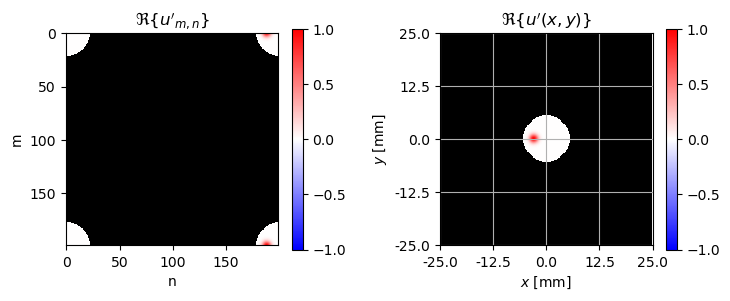

In [8]:
# create and plot input scalar field

def laguerre_gaussian(x,y, w0 = 1, p = 0, l = 0, x0 = 0, y0 = 0):
    """Laguerre-Gaussan envelope in polar coordinates"""
    x = x - x0
    y = y - y0
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)
    
    r2 = r**2
    r2 = r2/w0**2
    x = 2*r2
    
    amp = np.exp(-r2)
    norm0 = (np.abs(amp)**2).sum(axis = (-2,-1))
    
    upl = sp.genlaguerre(p,np.abs(l))(x) * x**(np.abs(l)/2)
    out = (upl*amp)*np.exp(1j*l*phi)
    
    norm1 = (np.abs(out)**2).sum(axis = (-2,-1))
    
    scale = (norm0/norm1) ** 0.5
    return out * scale[...,None,None]

Y = ymat_prime #alias
X = xmat_prime #alias

#: a Gaussian beam
input_field = np.sqrt(INTENSITY) * laguerre_gaussian(X,Y, w0 = WAIST, p = P, l = L, x0 = X0, y0 = Y0)

# perform a relative phase shift to simulate 
phasemat_prime = np.exp(1j*K0*ALPHA_MAT_PRIME * (-Z0)) * np.exp(1j*K0*ALPHA_MAT_PRIME [0,0] * (Z0))  
input_field = np.fft.ifft2(phasemat_prime * np.fft.fft2(input_field))

vmax = (np.abs(input_field)).max()
vmin = -vmax

input_field[aperture_mask] = 0. # invalidate non-propagating modes
power = FOURIER_PLANE_PIXEL_SIZE**2*(np.abs(input_field)**2).sum()

# for display purpose use NaNs 
input_field[aperture_mask] = np.nan

cmap = mpl.colormaps.get_cmap('bwr')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

cmap2 = mpl.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
cmap2.set_bad(color='black')

fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)

im = axes[0].imshow(np.real(input_field), vmin = vmin, vmax = vmax, cmap = cmap)
axes[0].set_title(r"$\Re\{u'_{m,n}\}$")
cbar = plt.colorbar(im)
#cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')

axes[0].set_xlabel("n")
axes[0].set_ylabel("m")

im = axes[1].imshow(np.fft.fftshift(np.real(input_field)),origin = "lower", cmap = cmap, vmin = vmin, vmax = vmax)
axes[1].set_title(r"$\Re\{u'(x,y)\}$")
cbar = plt.colorbar(im)
#cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')

set_ticks(axes[1], units = r"mm")
plt.tight_layout()

# remove NaNs
input_field[aperture_mask] = 0. # invalidate non-propagating modes

if SAVE_FIG:
    fname = f"fourier_plane_scalar_{INCIDENCE}.pdf"
    plt.savefig(fname)
    print(fname)


## Lens transform

Intensity and field in the focal plane of the objective lens in coordinate system S

### Scalar field

In [9]:
# Compute scalar field
# we omit the irrelevant phase term 1/i
output_field = lens_operator(input_field)

if SAVE_FIG:

    fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)
    
    vmax = np.abs(output_field).max()
    vmin = -vmax
    im = axes[0].imshow(np.fft.fftshift(np.abs(output_field)**2), vmin = 0, vmax = vmax**2, origin = "lower")
    axes[0].set_title(r"$\mathcal{I}(x,y)$")
    cbar = plt.colorbar(im)
    #cbar.set_label(r'[Wm$^{-2}$]')
    
    set_ticks(axes[0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um")
    
    im = axes[1].imshow(np.fft.fftshift((1j*output_field).real),origin = "lower", cmap = cmap, vmin = vmin, vmax = vmax)
    axes[1].set_title(r"$\Re\{iu\}(x,y)$")
    cbar = plt.colorbar(im)
    #cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')
    
    set_ticks(axes[1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um")
    plt.tight_layout()

    fname = f"image_plane_scalar_{INCIDENCE}.pdf"
    plt.savefig(fname)
    print(fname)

In [10]:
# propagate to z and plot

def scalar_plot(z):
    fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)

    h = z
    z = z/1e6 #convert to meters
    hlabel = f"{h:.1f}" #+ " $\mu$m"

    vmax = np.abs(output_field).max()
    vmin = -vmax
    
    output_field_z = phase_operator(output_field,z)

    im = axes[0].imshow(np.fft.fftshift(np.abs(output_field_z)**2), vmin = 0, vmax = vmax**2, origin = "lower")
    axes[0].set_title(r"$\mathcal{I}(x,y,z =$" + hlabel + r" $\mu$m)")
    cbar = plt.colorbar(im)
    #cbar.set_label(r'[Wm$^{-2}$]')
    
    set_ticks(axes[0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um")
    
    im = axes[1].imshow(np.fft.fftshift((1j*output_field_z).real),origin = "lower", cmap = cmap, vmin = vmin, vmax = vmax)
    axes[1].set_title(r"$\Re\{iu\}$"+"$(x,y,z =$" + hlabel + r" $\mu$m)")
    
    cbar = plt.colorbar(im)
    #cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')
    
    set_ticks(axes[1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um")
    plt.tight_layout()

iscalar_plot = interact(scalar_plot, z = (-5,5,0.1))

interactive(children=(FloatSlider(value=0.0, description='z', max=5.0, min=-5.0), Output()), _dom_classes=('wi…

## Vector field

In [11]:
# Convert scalar field to vector field

jones_field = scalar2jones(output_field, polarization = POLARIZATION)

vector_field = beam_operator(jones_field)

e_field = vector_field[...,1::2]
h_field = vector_field[...,-2::-2]

ex = e_field[...,0]
ey = e_field[...,1]
ez = e_field[...,2]

hx = h_field[...,0]
hy = h_field[...,1]
hz = h_field[...,2]

if SAVE_FIG:
    fig,axes = plt.subplots(3,2, figsize = FIGSIZE32)

    vmax = np.abs(ex).max()
    vmin = -vmax
    im = axes[0,0].imshow(np.real(np.fft.fftshift(1j*ex)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[0,0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",xlabel="")
    cbar = plt.colorbar(im)
    axes[0,0].set_title(r"$\Re\{i\mathcal{E}_x\}(x,y)$")

    vmax = np.abs(ey).max()
    vmin = -vmax
    im = axes[1,0].imshow(np.real(np.fft.fftshift(1j*ey)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[1,0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",xlabel="")
    cbar = plt.colorbar(im)
    axes[1,0].set_title(r"$\Re\{i\mathcal{E}_y\}(x,y)$")

    vmax = np.abs(ez).max()
    vmin = -vmax
    im = axes[2,0].imshow(np.imag(np.fft.fftshift(1j*ez)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[2,0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um")
    cbar = plt.colorbar(im)
    axes[2,0].set_title(r"$\Im\{i\mathcal{E}_z\}(x,y)$")

    vmax = np.abs(hx).max()
    vmin = -vmax
    im = axes[0,1].imshow(np.real(np.fft.fftshift(1j*hx)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[0,1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",xlabel="",ylabel = "")
    cbar = plt.colorbar(im)
    axes[0,1].set_title(r"$\Re\{i\mathcal{H}_x\}(x,y)$")

    vmax = np.abs(hy).max()
    vmin = -vmax
    im = axes[1,1].imshow(np.real(np.fft.fftshift(1j*hy)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[1,1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",xlabel="",ylabel = "")
    cbar = plt.colorbar(im)
    axes[1,1].set_title(r"$\Re\{i\mathcal{H}_y\}$(x,y)")

    vmax = np.abs(hz).max()
    vmin = -vmax
    im = axes[2,1].imshow(np.imag(np.fft.fftshift(1j*hz)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[2,1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",ylabel = "")
    cbar = plt.colorbar(im)
    axes[2,1].set_title(r"$\Im\{i\mathcal{H}_z\}$(x,y)")
    plt.tight_layout()


    fname = f"image_plane_vector_{INCIDENCE}.pdf"
    plt.savefig(fname)
    print(fname)

In [12]:
# convert scalar field to vector field and plot
def vector_plot(z):
    h = z
    z = z/1e6 #convert to meters
    
    hlabel = f"{h:.1f}" #+ " $\mu$m"
    
    output_field_z = phase_operator(output_field,z)
    
    jones_field_z = np.zeros(output_field_z.shape + (4,), dtype = output_field_z.dtype)
    jones_field_z[...,0] = output_field_z
    
    vector_field_z = beam_operator(jones_field_z)
    
    e_field = vector_field_z[...,1::2]
    h_field = vector_field_z[...,-2::-2]
    
    ex = e_field[...,0]
    ey = e_field[...,1]
    ez = e_field[...,2]
    
    hx = h_field[...,0]
    hy = h_field[...,1]
    hz = h_field[...,2]

    fig,axes = plt.subplots(3,2, figsize = FIGSIZE32)
    
    vmax = np.abs(ex).max()
    vmin = -vmax
    im = axes[0,0].imshow(np.real(np.fft.fftshift(1j*ex)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[0,0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",xlabel="")
    cbar = plt.colorbar(im)
    axes[0,0].set_title(r"$\Re\{i\mathcal{E}_x\}$"+"$(x,y,z =$" + hlabel + r" $\mu$m)")
    
    vmax = np.abs(ey).max()
    vmin = -vmax
    im = axes[1,0].imshow(np.real(np.fft.fftshift(1j*ey)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[1,0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",xlabel="")
    cbar = plt.colorbar(im)
    axes[1,0].set_title(r"$\Re\{i\mathcal{E}_y\}$"+"$(x,y,z =$" + hlabel + r" $\mu$m)")

    vmax = np.abs(ez).max()
    vmin = -vmax
    im = axes[2,0].imshow(np.imag(np.fft.fftshift(1j*ez)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[2,0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um")
    cbar = plt.colorbar(im)
    axes[2,0].set_title(r"$\Im\{i\mathcal{E}_z\}$"+"$(x,y,z =$" + hlabel + r" $\mu$m)")
    
    vmax = np.abs(hx).max()
    vmin = -vmax
    im = axes[0,1].imshow(np.real(np.fft.fftshift(1j*hx)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[0,1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",xlabel="",ylabel = "")
    cbar = plt.colorbar(im)
    axes[0,1].set_title(r"$\Re\{i\mathcal{H}_x\}$"+"$(x,y,z =$" + hlabel + r" $\mu$m)")
    
    vmax = np.abs(hy).max()
    vmin = -vmax
    im = axes[1,1].imshow(np.real(np.fft.fftshift(1j*hy)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[1,1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",xlabel="",ylabel = "")
    cbar = plt.colorbar(im)
    axes[1,1].set_title(r"$\Re\{i\mathcal{H}_y\}$"+"$(x,y,z =$" + hlabel + r" $\mu$m)")
    
    vmax = np.abs(hz).max()
    vmin = -vmax
    im = axes[2,1].imshow(np.imag(np.fft.fftshift(1j*hz)), origin = "lower",cmap = cmap,vmin = vmin, vmax = vmax)
    set_ticks(axes[2,1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),units = "um",ylabel = "")
    cbar = plt.colorbar(im)
    axes[2,1].set_title(r"$\Im\{i\mathcal{H}_z\}$"+"$(x,y,z =$" + hlabel + r" $\mu$m)")
    plt.tight_layout()

ivector_plot = interact(vector_plot, z = (-5,5,0.1))


interactive(children=(FloatSlider(value=0.0, description='z', max=5.0, min=-5.0), Output()), _dom_classes=('wi…

## xz profile

### Scalar beam

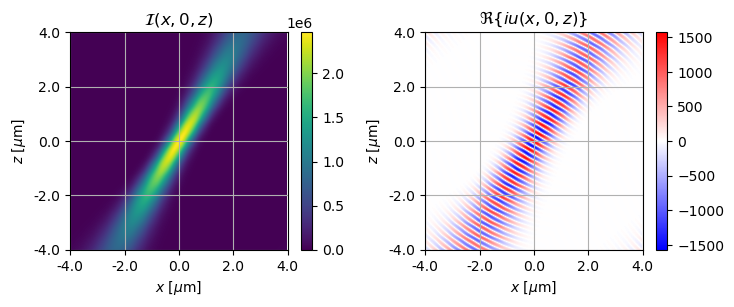

In [13]:
# Scan over z axis and plot sidde profile

fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)

output_field_zx = np.asarray([phase_operator(output_field,z)[0] for z in Z])

vmax = np.abs(output_field_zx).max()
vmin = -vmax

im = axes[0].imshow(np.fft.fftshift(np.abs(output_field_zx)**2,axes = 1), origin = "lower", vmin = 0)
cbar = plt.colorbar(im)
#cbar.set_label(r'[Wm$^{-2}$]')

axes[0].set_title(r"$\mathcal{I}(x,0,z)$")

set_ticks(axes[0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),shape = (N,N),nticks = (5,5),units = r"um", ylabel = "$z$")


im = axes[1].imshow(np.fft.fftshift(np.real(1j*output_field_zx),axes = 1),cmap = cmap, vmin = vmin, vmax = vmax, origin = "lower")
cbar = plt.colorbar(im)
#cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')

set_ticks(axes[1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),shape = (N,N),nticks = (5,5),units = r"um", ylabel = "$z$")

axes[1].set_title(r"$\Re\{iu(x,0,z)\}$")

plt.tight_layout()


if SAVE_FIG:
    fname = f"side_profile_scalar_{INCIDENCE}.pdf"
    plt.savefig(fname)
    print(fname)

### Vector field

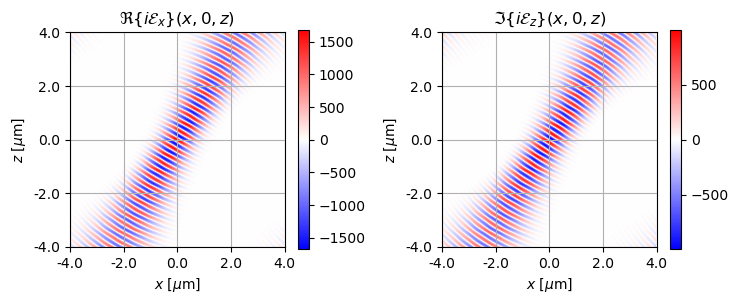

In [14]:
# scan over z axis and plot side profile

fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)

vector_field_zx = np.asarray([beam_operator(scalar2jones(phase_operator(output_field,z)))[0] for z in Z])


vmax = np.abs(vector_field_zx[...,1]).max()
vmin = -vmax

im = axes[0].imshow(np.fft.fftshift(np.real(1j*vector_field_zx[...,1]),axes = 1),cmap = cmap, vmin = vmin, vmax = vmax, origin = "lower")
cbar = plt.colorbar(im)
#cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')

set_ticks(axes[0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),shape = (N,N),nticks = (5,5),units = r"um", ylabel = "$z$")

axes[0].set_title(r"$\Re\{i\mathcal{E}_x\}(x,0,z)$")

vmax = np.abs(vector_field_zx[...,5]).max()
vmin = -vmax

im = axes[1].imshow(np.fft.fftshift(np.imag(1j*vector_field_zx[...,5]),axes = 1),cmap = cmap, vmin = vmin, vmax = vmax, origin = "lower")
cbar = plt.colorbar(im)
#cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')

set_ticks(axes[1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),shape = (N,N),nticks = (5,5),units = r"um", ylabel = "$z$")

axes[1].set_title(r"$\Im\{i\mathcal{E}_z\}(x,0,z)$")

plt.tight_layout()

if SAVE_FIG:
    fname = f"side_profile_vector_{INCIDENCE}.pdf"
    plt.savefig(fname)
    print(fname)

## Poynting vector

Demonstrates how to compute the Poynting vector

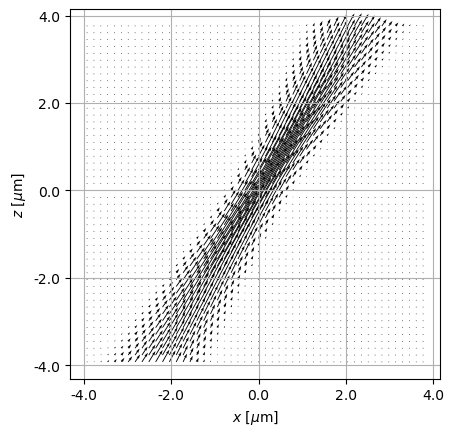

In [15]:
# Compute and plot the Poyting vector

# obtain E field from f
e_field = vector_field_zx[...,1::2] 
# obtain H field from f
h_field = vector_field_zx[...,-2::-2]
# compute Poytning vector
p_field = 0.5*np.cross(e_field,np.conj(h_field)).real

DIVISOR = 4

NP = N//DIVISOR

X = np.arange(0, NP, 1)
Y = np.arange(0, NP, 1)

U = np.fft.fftshift(p_field[::DIVISOR,::DIVISOR,0],axes = 1).real
V = np.fft.fftshift(p_field[::DIVISOR,::DIVISOR,2],axes = 1).real

fig, ax = plt.subplots()
q = ax.quiver(X,Y, U,V,scale=10*V.max())

set_ticks(ax,size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),shape = (NP,NP),nticks = (5,5),units = r"um", ylabel = "$z$")

ax.set_aspect("equal")
plt.show()

## Comparison with paraxial Gaussian beam

Here, we compare the results with a paraxial Gaussian beam $\Psi$. 

In [16]:
#only works if we have on axis propagation
assert X0 == 0
assert Y0 == 0
assert Z0 == 0

Z01 = K * WAIST**2/2

WAIST_FOCUS = WAIST * FOCAL_LENGTH/Z01*REFRACTIVE_INDEX

Z02 = K * WAIST_FOCUS**2/2

W = WAIST_FOCUS *np.sqrt(1+(Z/Z02)**2)

Y = ymat[0]
X = xmat[0]
R2 = (X)**2 + (Y)**2
Q = Z / (Z**2 + Z02**2)
KPHASE = np.exp(1j*K*Z[:,None])
QPHASE = np.exp(1j*K*R2/2*Q[:,None])
ETAPHASE = np.exp(-1j*np.arctan2(Z[:,None],Z02))
PHASE = KPHASE * QPHASE * ETAPHASE

paraxial_z = np.sqrt(INTENSITY)*(WAIST/W[:,None])* np.exp(-(R2/W[:,None]**2)) * PHASE

fig,axes = plt.subplots(1,2, figsize = FIGSIZE12)

vmax = np.abs(output_field_zx).max()
vmin = -vmax

im = axes[0].imshow(np.fft.fftshift(np.real(1j*output_field_zx),axes = 1),cmap = cmap, vmin = vmin, vmax = vmax, origin = "lower")
cbar = plt.colorbar(im)
#cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')

set_ticks(axes[0],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),shape = (N,N),nticks = (5,5),units = r"um", ylabel = "$z$")

axes[0].set_title(r"$\Re\{iu\}(x,0,z)$")

im = axes[1].imshow(np.fft.fftshift(np.real(paraxial_z),axes = 1),cmap = cmap,  origin = "lower", vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im)
#cbar.set_label(r'[W$^{1/2}$m$^{-1}$]')

set_ticks(axes[1],size = (IMAGE_PLANE_SIZE,IMAGE_PLANE_SIZE),shape = (N,N),nticks = (5,5),units = r"um", ylabel = "")

axes[1].set_title(r"$\Re\{\Psi\}(x,0,z)$")


plt.tight_layout()

if SAVE_FIG:
    fname = f"side_profile_paraxial_{INCIDENCE}.pdf"
    plt.savefig(fname)
    print(fname)

AssertionError: 